# Dynamic programming exercises

Natasha Watkins

In [206]:
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
from scipy.stats import lognorm
from scipy.interpolate import interp1d
from scipy.optimize import fminbound

## Problem 2

1. State variables are $y_t$, $k_t$ and $z_t$
1. Control variables are $c_t$ and $i_t$
1. The Bellman equation is $V(k_t, z_t) = \max_{c_t} u(c_t) + \beta \mathbb{E} V(k_{t+1}, z_{t+1})$ 

**Part 4**

In [220]:
γ = 0.5
β = 0.96
δ = 0.05
α = 0.4
σ = 0.2
N = 100

In [221]:
lb_k = 0.4
ub_k = 100
size_k = 100  # Number of grid points
k_grid = np.linspace(lb_k, ub_k, size_k)
z_grid = lognorm.rvs(s=σ, size=N)

In [209]:
def U(k, kprime, z, δ, γ, α):
    c = (1 - δ) * k + z * k**α - kprime
    return c**(1 - γ) / (1 - γ)

In [210]:
def bellman_operator(V, k_grid, z, δ, γ, α, β):
    
    # Apply cubic interpolation to V
    V_func = interp1d(k_grid, V, kind='cubic', fill_value='extrapolate')

    # Initialize array for operator and policy function
    TV = np.empty_like(V)
    k_star = np.empty_like(TV)

    for i, k in enumerate(k_grid):
        def objective(kprime):
            return -U(k, kprime, z.mean(), δ, γ, α) - β * V_func(kprime)
        kprime_star = fminbound(objective, 1e-6, k-1e-6)
        k_star[i] = kprime_star
        TV[i] = -objective(kprime_star)
    return TV, k_star

In [211]:
tol = 1e-4
diff = 1e3 
max_iter = 500 
V = np.zeros(size_k)  # initial guess at value function
i = 1 
while diff > tol and i < max_iter:
    TV, k_star = bellman_operator(V, k_grid, z, δ, γ, α, β)
    diff = (np.abs(V - TV)).max()  # check distance
    V = TV
    i += 1

if i < max_iter:
    print(f'Value function converged after this many iterations: {i}')
else:
    print('Value function did not converge')            


VF = V # solution to the functional equation

Value function converged after this many iterations: 253


In [212]:
c_star = (1 - δ) * k_grid + z.mean() * k_grid**α - k_star

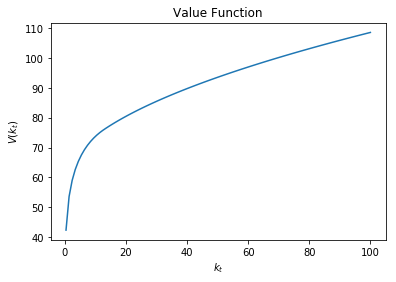

In [213]:
plt.plot(k_grid, VF)
plt.xlabel('$k_t$')
plt.ylabel('$V(k_t)$')
plt.title('Value Function')
plt.show()

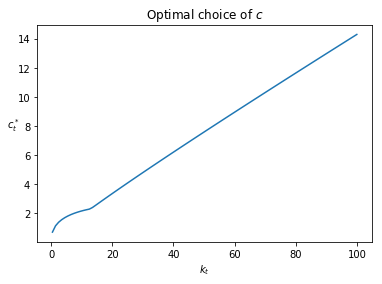

In [214]:
plt.plot(k_grid, c_star)
plt.xlabel('$k_t$')
plt.ylabel('$c_t^*$', rotation=0)
plt.title('Optimal choice of $c$')
plt.show()

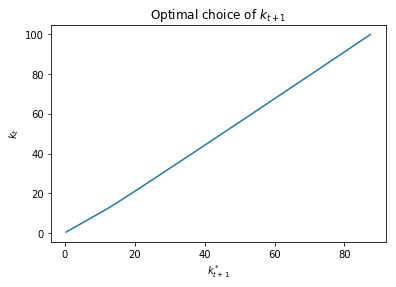

In [216]:
plt.plot(k_star, k_grid)
plt.xlabel('$k^*_{t+1}$')
plt.ylabel('$k_{t}$')
plt.title('Optimal choice of $k_{t+1}$')
plt.show()

## Problem 3

* The Bellman equation is $V(k_t, z_t) = \max_{c_t} u(c_t, z_t) + \beta \mathbb{E}_{z_{t+1}|z_t} V(k_{t+1}, z_{t+1})$

In [223]:
import quantecon as qe

ρ = 0.8
σ_υ = 0.1
size_υ = 3
max_iter = 500 
V = np.zeros(size_k)  # initial guess at value function

In [232]:
def solve_Vf(V, k_grid, z, δ, γ, α, β, tol=1e-4, max_iter=1000):
    
    diff = 1e3 
    i = 1

    while diff > tol and i < max_iter:
        TV, k_star = bellman_operator(V, k_grid, z, δ, γ, α, β)
        diff = (np.abs(V - TV)).max()  # check distance
        V = TV
        i += 1

    if i < max_iter:
        print(f'Value function converged after this many iterations: {i}')
    else:
        print('Value function did not converge')  
        
    c_star = (1 - δ) * k_grid + z.mean() * k_grid**α - k_star

    return V, c_star, k_star # solution to the functional equation

In [239]:
mc = qe.tauchen(ρ, σ_υ, n=size_υ)
Vf, c_star = np.zeros((size_k, size_υ)), np.zeros((size_k, size_υ))
k_star = np.zeros((size_k, size_υ))

for n in range(size_υ):
    z = np.exp(mc.simulate(N, init=mc.state_values[n]))
    Vf[:, n], c_star[:, n], k_star[:, n] = solve_Vf(V, k_grid, z, δ, γ, α, β, tol=1e-3)

Value function converged after this many iterations: 197
Value function converged after this many iterations: 200
Value function converged after this many iterations: 197


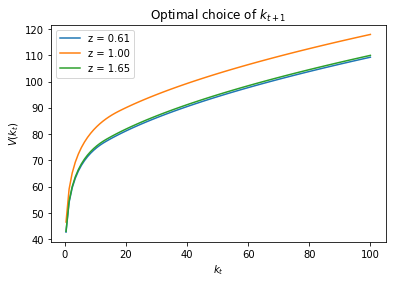

In [246]:
for n in range(size_υ):
    plt.plot(k_grid, Vf[:, n], 
             label=f'z = {np.exp(mc.state_values[n]):.2f}')

plt.title('Optimal choice of $k_{t+1}$')
plt.xlabel('$k_t$')
plt.ylabel('$V(k_t)$')
plt.legend()
plt.show()

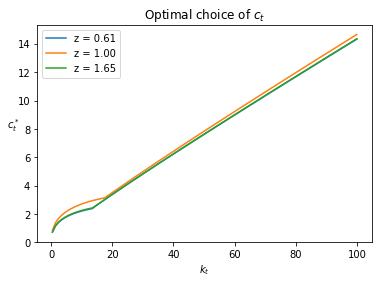

In [247]:
for n in range(size_υ):
    plt.plot(k_grid, c_star[:, n], 
             label=f'z = {np.exp(mc.state_values[n]):.2f}')
    
plt.title('Optimal choice of $c_{t}$')
plt.xlabel('$k_t$')
plt.ylabel('$c_t^*$', rotation=0)
plt.legend()
plt.show()

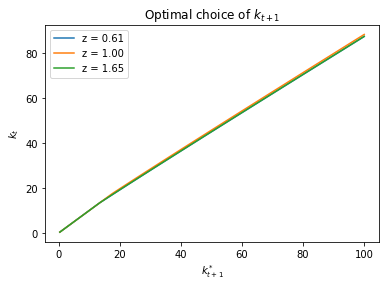

In [248]:
for n in range(size_υ):
    plt.plot(k_grid, k_star[:, n], 
             label=f'z = {np.exp(mc.state_values[n]):.2f}')
    
plt.title('Optimal choice of $k_{t+1}$')
plt.xlabel('$k^*_{t+1}$')
plt.ylabel('$k_{t}$')
plt.legend()
plt.show()